In [1]:
#------------------------------------------------------------------------------------------------
#  Copyright (c) Shell Global Solutions International B.V. All rights reserved.
#  Licensed under the MIT License. See License.txt in the project root for license information.
#------------------------------------------------------------------------------------------------

# Benchmark 5: Primary drainage centrifuge experiment

This notebook shows the comparison of 1D2P solver results (as discussed in [1], section 3.3 and figure 5) to literature reference data [2]. 

References:

1. Simultaneous determination of relative permeability and capillary pressure from an unsteady-state core flooding experiment? 
Steffen Berg, Harm Dijk, Evren Unsal, Ronny Hofmann, Bochao Zhao, Vishal Raju Ahuja,
https://doi.org/10.1016/j.compgeo.2024.106091


2. COMPARISON OF FOUR NUMERICAL SIMULATORS FOR SCAL EXPERIMENTS,
Roland Lenormand, Kjetil Lorentzen, Jos G. Maas and Douglas Ruth, SCA2016-006
https://www.jgmaas.com/SCA/2016/SCA2016-006.pdf


SCORES reference data used below have been downloaded (with permission for usage in this benchmark given by Jos Maas, email 21 September 2023) from https://www.jgmaas.com.

Created on 01.07.2025 by Harm Dijk

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns # we use seaborn to get nice plots (can be left out)
sns.set_style('whitegrid')
import numpy as np
import pandas as pd

In [3]:
from scallib001.displacementmodel1D2P001 import DisplacementModel1D2P # the solver
import scallib001.relpermlib001 as rlplib # relperm and capillary pressure library

## Read the SCORES model and simulated data

We make use of a dedicated python script to extract data from Excel spreadsheets. The script formats data and converts units ready for use with 1D2P.

In [4]:
from scores_benchmark_data.read_scores_data import read_scores_data

In [5]:
CASE_LABEL = 'Case5 ... Primary drainage centrifuge experiment' # this will be used in plot title

EXCEL_FILE = 'Case_5_SCA_SCORES.csv'

In [6]:
scores = read_scores_data( directory='scores_benchmark_data', excel_file_name=EXCEL_FILE )

Read scores data file Case_5_SCA_SCORES.csv ...
   Unit conversions applied on data to change from scores to scallib conventions:
    - all fluid density data to kg/m3
    - all flow rate data to cm3/min
    - all time axis data to hour
Data converted.


In [7]:
scores.schedule

,StartTime,RPM,Acceleration,InjRate,FracFlow
0,0.0,200.0,127.831116,0.0,1.0
1,5.0,500.0,798.944476,0.0,1.0
2,10.0,1000.0,3195.777905,0.0,1.0
3,15.0,2000.0,12783.111620,0.0,1.0
4,20.0,3000.0,28762.001146,0.0,1.0
5,25.0,5000.0,79894.447627,0.0,1.0
6,30.0,5000.0,79894.447627,0.0,1.0


In [8]:
scores.print_summary()

Summary of scores data:

Excel file: Case_5_SCA_SCORES.csv

excel_file_name : Case_5_SCA_SCORES.csv
Gridblocks : 100
VertHor : V
gravity_multiplier : 1.0
LevJ : OFF
Core_length : 10.0
Core_diam : 4.0
Core_area : 12.566370614359172
Porosity : 0.25
Permeability : 100.0
Flooding :  Drainage 
Swi : 0.99999
Water_density : 1000.0
Oil_density : 800.0
Water_visc : 1.0
Oil_visc : 5.0
IFT : 0.03
Radius_centre_CM : 29.142
Startup_time_SEC : 0.0
rpm_limit : 5000.0
T_end_HOUR : 30.0
Start_timestep_SEC : 0.1
Max_timestep_MIN : 10.0
Max_sat_change : 0.01
Max_incr : 1.2

Dataframe sw_krw :


,Sw,krw
0,0.300,0.000000
1,0.314,0.000008
2,0.329,0.000068
3,0.343,0.000230
4,0.357,0.000544
...,...,...
45,0.943,0.775000
46,0.957,0.827000
47,0.971,0.883000
48,0.986,0.940000


Dataframe sw_kro :


,Sw,kro
0,0.300,1.000000
1,0.314,0.960000
2,0.329,0.920000
3,0.343,0.881000
4,0.357,0.843000
...,...,...
45,0.943,0.006660
46,0.957,0.003750
47,0.971,0.001670
48,0.986,0.000417


Dataframe sw_pc :


,Sw,Pc
0,0.300,2.068
1,0.314,1.609
2,0.329,1.316
3,0.343,1.114
4,0.357,0.965
...,...,...
45,0.943,0.149
46,0.957,0.147
47,0.971,0.144
48,0.986,0.141


Dataframe schedule :


,StartTime,RPM,Acceleration,InjRate,FracFlow
0,0.0,200.0,127.831116,0.0,1.0
1,5.0,500.0,798.944476,0.0,1.0
2,10.0,1000.0,3195.777905,0.0,1.0
3,15.0,2000.0,12783.111620,0.0,1.0
4,20.0,3000.0,28762.001146,0.0,1.0
5,25.0,5000.0,79894.447627,0.0,1.0
6,30.0,5000.0,79894.447627,0.0,1.0


Dataframe result_data :


,INDEX,Time,Meansat,top_sat,bot_sat,water_prod
0,1.0,0.000028,0.999990,0.999990,0.999990,0.00000
1,2.0,0.000048,0.999990,0.999990,0.999990,0.00000
2,3.0,0.000064,0.999990,0.999989,0.999991,0.00000
3,4.0,0.000083,0.999990,0.999989,0.999991,0.00000
4,5.0,0.000105,0.999990,0.999989,0.999991,0.00000
...,...,...,...,...,...,...
1515,1516.0,27.535692,0.321745,0.300862,1.000000,21.37860
1516,1517.0,28.034944,0.321423,0.300787,1.000000,21.38871
1517,1518.0,28.634028,0.321093,0.300717,1.000000,21.39909
1518,1519.0,29.352917,0.320759,0.300653,1.000000,21.40962


## Check some data coming from SCORES

- relperms and capillary pressure

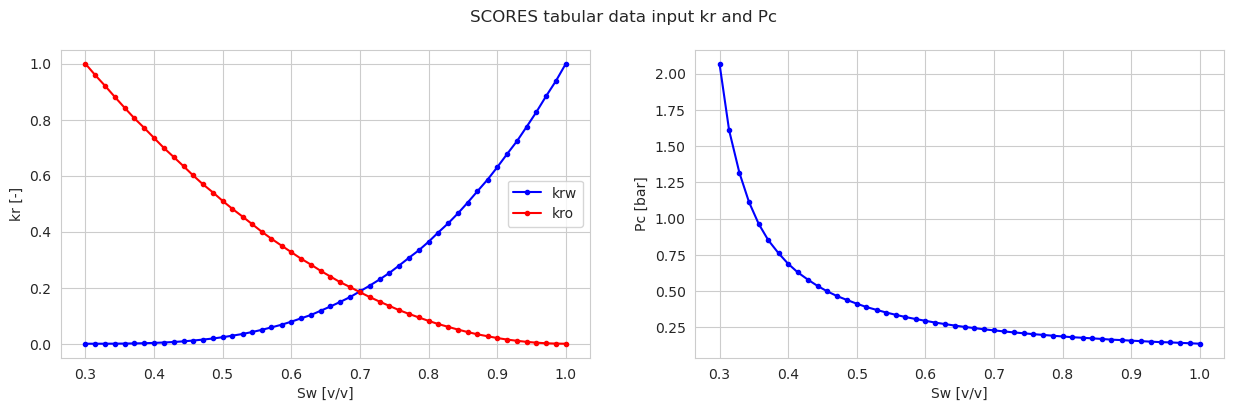

In [9]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( scores.sw_krw.Sw, scores.sw_krw.krw, 'b.-', label='krw')
plt.plot( scores.sw_kro.Sw, scores.sw_kro.kro, 'r.-', label='kro')
plt.ylabel('kr [-]')
plt.xlabel('Sw [v/v]');
plt.legend()

plt.subplot(1,2,2)
plt.plot( scores.sw_pc.Sw, scores.sw_pc.Pc, 'b.-');
plt.ylabel('Pc [bar]')
plt.xlabel('Sw [v/v]');

plt.suptitle('SCORES tabular data input kr and Pc');

# Convert to input for 1D2P

## Define a water-oil relperm model based on SCORES tabular data

- we use monotonic cubic interpolation of the tabular data, i.e., Rlp2PCubic from rlplib

In [10]:
rlp_model1 = rlplib.Rlp2PCubic( scores.sw_krw.Sw.values, 
                                scores.sw_krw.krw.values, 
                                scores.sw_kro.kro.values, 
                                lex=0, # no left extrapolation
                                rex=0, # no right extrapolation
                              )

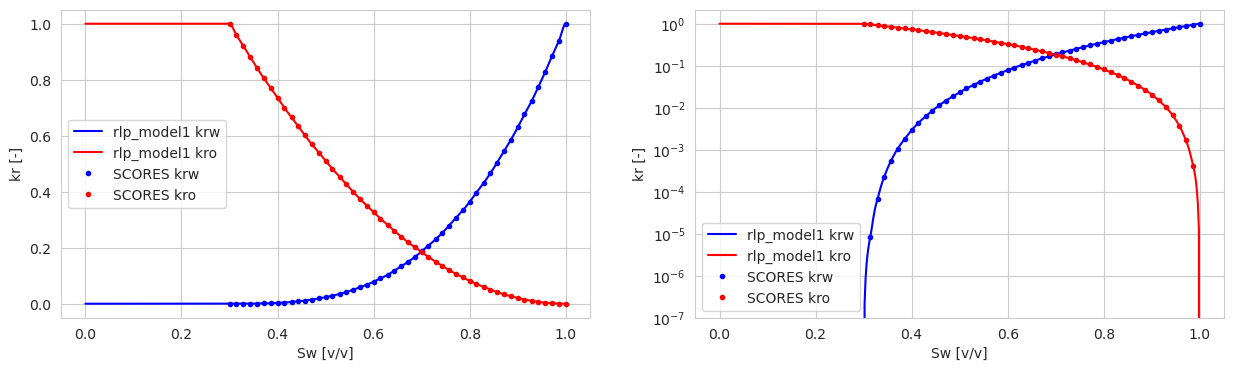

In [11]:
swv = np.linspace(0,1,501) # Sw values to plot rlp_model1

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot( swv, rlp_model1.calc_kr1( swv ), 'b', label='rlp_model1 krw')
plt.plot( swv, rlp_model1.calc_kr2( swv ), 'r', label='rlp_model1 kro')

plt.plot( scores.sw_krw.Sw, scores.sw_krw.krw, 'b.', label='SCORES krw')
plt.plot( scores.sw_kro.Sw, scores.sw_kro.kro, 'r.', label='SCORES kro')

plt.xlabel('Sw [v/v]')
plt.ylabel('kr [-]')

plt.legend();

plt.subplot(1,2,2)
plt.plot( swv, rlp_model1.calc_kr1( swv ), 'b', label='rlp_model1 krw')
plt.plot( swv, rlp_model1.calc_kr2( swv ), 'r', label='rlp_model1 kro')

plt.plot( scores.sw_krw.Sw, scores.sw_krw.krw, 'b.', label='SCORES krw')
plt.plot( scores.sw_kro.Sw, scores.sw_kro.kro, 'r.', label='SCORES kro')

plt.xlabel('Sw [v/v]')
plt.ylabel('kr [-]')

plt.legend();
plt.yscale('log');

## Define a water Pc model based on SCORES tabular data

- we use monotonic cubic interpolation of the tabular data, i.e., CubicInterpolator from rlplib

In [12]:
cpr_model1 = rlplib.CubicInterpolator( scores.sw_pc.Sw.values, # v/v
                                       scores.sw_pc.Pc.values, # bar
                                       lex=1, # left extrapolation
                                       rex=1, # right extrapolation
                                     );

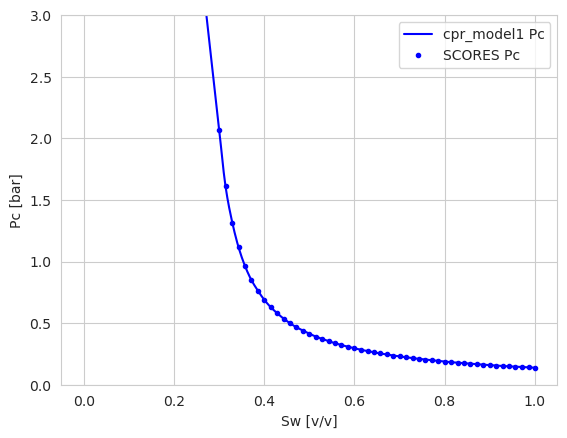

In [13]:
swv = np.linspace(0,1,501) # Sw values to plot cpr_model1

plt.plot( swv, cpr_model1.calc( swv )[0], 'b', label='cpr_model1 Pc')
plt.plot( scores.sw_pc.Sw, scores.sw_pc.Pc, 'b.', label='SCORES Pc');

plt.xlabel('Sw [v/v]')
plt.ylabel('Pc [bar]')

plt.ylim(0,3);

plt.legend();

# Simulate the experiment using SCORES parameters

## The time schedule for simulation is taken from SCORES

In [14]:
scores.schedule

,StartTime,RPM,Acceleration,InjRate,FracFlow
0,0.0,200.0,127.831116,0.0,1.0
1,5.0,500.0,798.944476,0.0,1.0
2,10.0,1000.0,3195.777905,0.0,1.0
3,15.0,2000.0,12783.111620,0.0,1.0
4,20.0,3000.0,28762.001146,0.0,1.0
5,25.0,5000.0,79894.447627,0.0,1.0
6,30.0,5000.0,79894.447627,0.0,1.0


## Solve using 1D2P

First set up the model, then solve it. We take 'movie' snapshots at the times specified in the SCORES result_data table.

In [15]:
scores.Gridblocks

100

In [16]:
model1 = DisplacementModel1D2P(    
    NX             = scores.Gridblocks,
    core_length    = scores.Core_length, # cm
    core_area      = scores.Core_area, # cm2
    permeability   = scores.Permeability, # mDarcy
    porosity       = scores.Porosity, # v/v
    sw_initial     = scores.Swi, # v/v
    viscosity_w    = scores.Water_visc, # cP
    viscosity_n    = scores.Oil_visc, # cP
    density_w      = scores.Water_density, # kg/m3
    density_n      = scores.Oil_density, # kg/m3
    rlp_model      = rlp_model1,
    cpr_model      = cpr_model1,
    time_end       = scores.T_end_HOUR, # hour
    movie_schedule = scores.result_data.Time.values, # hour
    acceleration_schedule = scores.schedule,
    flow_direction = 'drainage',
    centrifuge_rmid = scores.Radius_centre_CM,  # cm
    max_nr_iter    = 10,
 );

Now solve the model and retrieve results:

In [17]:
results = model1.solve().results

# Compare 1D2P outcome to SCORES results

These are the results provided by SCORES:

In [18]:
scores.result_data.columns

Index(['INDEX', 'Time', 'Meansat', 'top_sat', 'bot_sat', 'water_prod'], dtype='object')

## Water saturation at inner radius edge of plug

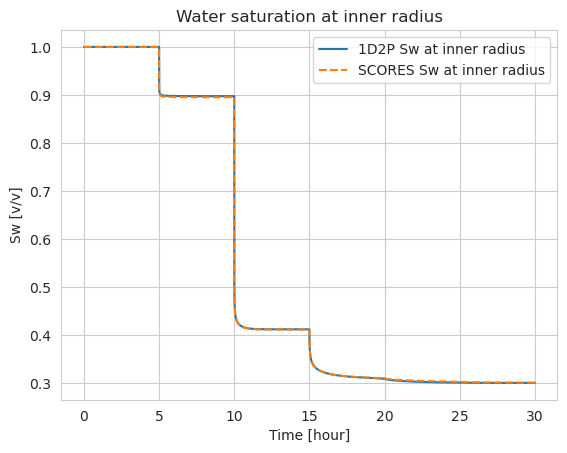

In [19]:
plt.plot( results.movie_time, results.movie_sw[:,0], label='1D2P Sw at inner radius')
plt.plot( scores.result_data.Time, scores.result_data.top_sat, '--', label='SCORES Sw at inner radius');
plt.legend()
plt.xlabel("Time [hour]");
plt.ylabel("Sw [v/v]");
plt.title("Water saturation at inner radius");

## Average water saturation in plug

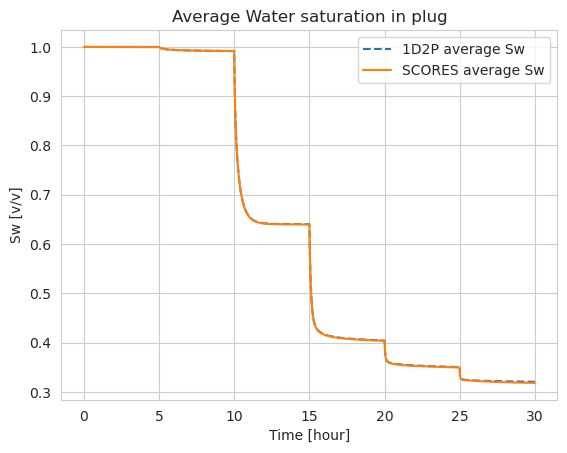

In [20]:
plt.plot( scores.result_data.Time, scores.result_data.Meansat, "--", label='1D2P average Sw');
plt.plot(results.tss_table.TIME, results.tss_table.Sw_avg, label='SCORES average Sw')
plt.legend()
plt.xlabel("Time [hour]");
plt.ylabel("Sw [v/v]");
plt.title("Average Water saturation in plug");

# Cumulative water produced from plug

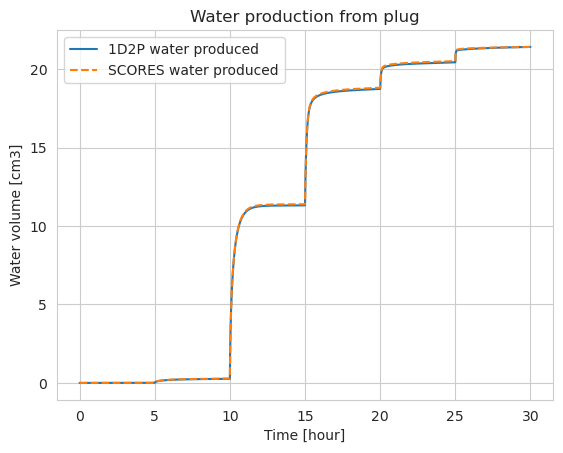

In [21]:
plt.plot( results.tss_table.TIME, results.tss_table.CumWATER, label='1D2P water produced')
plt.plot( scores.result_data.Time, scores.result_data.water_prod, "--", label='SCORES water produced');
plt.legend()
plt.xlabel("Time [hour]");
plt.ylabel("Water volume [cm3]");
plt.title("Water production from plug");

# Conclusion

1D2P is in line with literature data, 1D2P and SCORES give identical results.

## Solver performance

For information of 1D2P solver performance, the plots below give a summary of Newton iterations and simulation timestep sizes:

- the 1D2P solver uses 3 to 4 Newton iterations to solve a timestep
- the timestep size is dictated by the movie_schedule (defined by reported SCORES time steps), i.e., there are no timestep cutbacks due to Newton solver problems

In [22]:
# Calculate the timestep size used by SCORES:
scores_DTIME = np.hstack( ([scores.result_data.Time.values[0]],
                           (scores.result_data.Time.values[1:] - scores.result_data.Time.values[:-1])) )

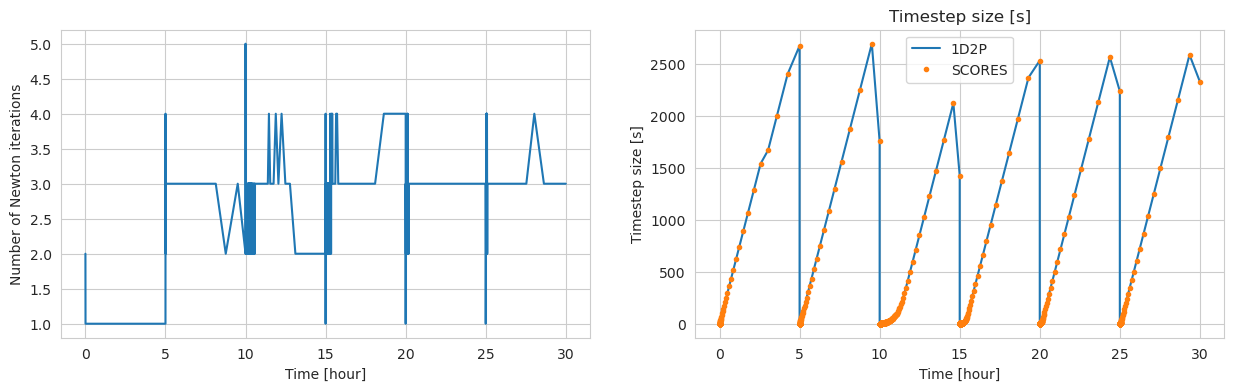

In [23]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(results.tss_table.TIME, results.movie_nr)
plt.xlabel('Time [hour]')
plt.ylabel('Number of Newton iterations')

plt.subplot(1,2,2)

plt.plot(results.tss_table.TIME, results.tss_table.DTIME*3600, label='1D2P')
plt.plot(scores.result_data.Time, scores_DTIME*3600, '.', label='SCORES')
plt.legend()
plt.title('Timestep size [s]')
plt.xlabel('Time [hour]')
plt.ylabel('Timestep size [s]');